# Visual Question Answering using Multimodal Transformer Models

## Import necessary libraries & set up the environment

In [1]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled, Dataset, DatasetDict
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)
import pandas as pd
# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score
import random


VQAV2_FILEPATH = "./VQAv2 Annotations Preprocessed"
TRAIN_IMAGES_FILEPATH = "train2014/train2014"
VAL_IMAGES_FILEPATH = "val2014/val2014"
OUTPUT_DIR = "Checkpoint_VQA_3129_Dropped_NaN"

MODEL_NAME = 'bert_base_g_vit_hidden_x1_yes_no_untouched'
TEXT_MODEL = 'bert-base-uncased'
# 'bert-base-uncased'
# 'roberta-base'
# 'google/vit-base-patch16-224-in21k'
# 'microsoft/beit-base-patch16-224-pt22k-ft22k'
IMAGE_MODEL = 'google/vit-base-patch16-224-in21k'
REDUCED_YES_NO = False

SAMPLES = 12468 
SAMPLE_BOOL = False
RANDOM_STATE = 12345


2023-04-15 15:58:51.034929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 15:58:52.139078: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 15:58:53.844943: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory
2023-04-15 15:58:53.845078: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dler

In [2]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

/tmp/ipykernel_25244/2343905411.py:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


cuda:0
NVIDIA GeForce RTX 3090


In [4]:
def map_to_ids(df):
    unique_answers = df['answer'].unique()
    answer_to_id = {answer: idx for idx, answer in enumerate(unique_answers)}
    id_to_answer = {idx: answer for answer, idx in answer_to_id.items()}

    df['answer_ids'] = df['answer'].map(answer_to_id)

    return df, answer_to_id, id_to_answer

def map_to_answers(df, id_to_answer):
    df['mapped_answers'] = df['answer_ids'].map(id_to_answer)
    return df

def filter_rows_with_duplicates(df):
    def process_row(row):
        counts = row.value_counts()
        filtered_values = counts[counts >= 5]
        if len(filtered_values) > 0:
            return filtered_values.index[0]
        else:
            return None
    result = df.apply(process_row, axis=1)
    filtered_result = result.dropna()
    return pd.DataFrame(filtered_result, columns=['Filtered_Value'])

In [5]:
df_combined = pd.read_csv(os.path.join(
    VQAV2_FILEPATH, "VQAv2_train_preprocessed.csv"))
df_combined


,question,answer,answer_type,image_id,label
0,What is this photo taken looking through?,net,other,train2014/train2014/COCO_train2014_00000045875...,1036
1,What position is this man playing?,pitcher,other,train2014/train2014/COCO_train2014_00000045875...,2092
2,What color is the players shirt?,orange,other,train2014/train2014/COCO_train2014_00000045875...,2693
3,Is this man a professional baseball player?,yes,yes/no,train2014/train2014/COCO_train2014_00000045875...,2259
4,What color is the snow?,white,other,train2014/train2014/COCO_train2014_00000026214...,2580
...,...,...,...,...,...
413428,How many keyboards are there?,2,number,train2014/train2014/COCO_train2014_00000052428...,2013
413429,What color is the keyboard?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486
413430,Is there a computer mouse on the desk?,no,yes/no,train2014/train2014/COCO_train2014_00000052428...,2194
413431,What color is the computer?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486


In [6]:
yes_no_questions = df_combined.index[df_combined['answer_type']
                                     == 'yes/no'].tolist()
print(len(yes_no_questions))
random.shuffle(yes_no_questions)

df_combined_dropped = df_combined
if REDUCED_YES_NO:
  df_combined_dropped = df_combined.drop(yes_no_questions[:120000])

# df_combined_dropped.reset_index()
df_combined_dropped


166881


,question,answer,answer_type,image_id,label
0,What is this photo taken looking through?,net,other,train2014/train2014/COCO_train2014_00000045875...,1036
1,What position is this man playing?,pitcher,other,train2014/train2014/COCO_train2014_00000045875...,2092
2,What color is the players shirt?,orange,other,train2014/train2014/COCO_train2014_00000045875...,2693
3,Is this man a professional baseball player?,yes,yes/no,train2014/train2014/COCO_train2014_00000045875...,2259
4,What color is the snow?,white,other,train2014/train2014/COCO_train2014_00000026214...,2580
...,...,...,...,...,...
413428,How many keyboards are there?,2,number,train2014/train2014/COCO_train2014_00000052428...,2013
413429,What color is the keyboard?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486
413430,Is there a computer mouse on the desk?,no,yes/no,train2014/train2014/COCO_train2014_00000052428...,2194
413431,What color is the computer?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486


In [7]:
import json

with open(f"{VQAV2_FILEPATH}/VQAv2_answer_mapping.json", "r") as json_file:
    answer_to_id = json.load(json_file)

answer_space = list(answer_to_id.keys())
id_to_answer = {v: k for k, v in answer_to_id.items()}


In [8]:

train_df, test_df = train_test_split(df_combined_dropped, test_size=0.2, random_state=RANDOM_STATE,
                                     shuffle=True, stratify=df_combined_dropped['answer_type'])

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label'],
        num_rows: 330746
    })
    test: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label'],
        num_rows: 82687
    })
})

In [9]:
# df_combined['answer_type'].value_counts(normalize=True) * 100

print(train_df['answer_type'].value_counts(normalize=True) * 100)
print(train_df['answer_type'].value_counts())
print()
print(test_df['answer_type'].value_counts(normalize=True) * 100)
print(test_df['answer_type'].value_counts())


other     46.458007
yes/no    40.364812
number    13.177181
Name: answer_type, dtype: float64
other     153658
yes/no    133505
number     43583
Name: answer_type, dtype: int64

other     46.458331
yes/no    40.364265
number    13.177404
Name: answer_type, dtype: float64
other     38415
yes/no    33376
number    10896
Name: answer_type, dtype: int64


In [10]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join(VQAV2_FILEPATH, data[id]['image_id']))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

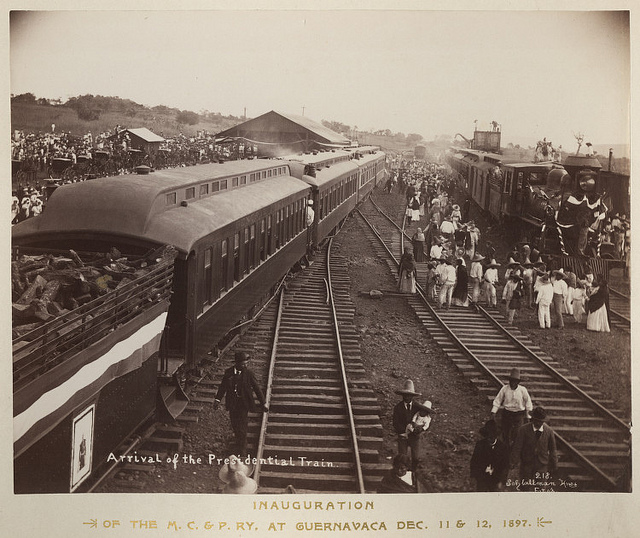

Question:	 What type of train is depicted?
Answer:		 passenger (Label: 2927)


In [11]:
showExample()

### Create a Multimodal Collator for the Dataset

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [12]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]): 
        processed_images = self.preprocessor(
#             images=[Image.open(os.path.join("..","input","textvqa","TextVQA", "train_images", image_id + ".jpg")).convert('RGB') for image_id in images],
            
            images=[Image.open(os.path.join(VQAV2_FILEPATH, image_id)).convert(
                'RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we explore **"Fusion" Models**, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering). 

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the *Cross-Entropy Loss* as the loss function.

In [13]:
class MultimodalVQAModel_modified(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'roberta-base',
            pretrained_image_name: str = 'microsoft/beit-base-patch16-224-pt22k-ft22k',
            size: int = 1):
     
        super(MultimodalVQAModel_modified, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        
        self.encoders_hidden_size = self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(self.encoders_hidden_size, self.encoders_hidden_size*size),
            nn.LayerNorm(self.encoders_hidden_size*size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.encoders_hidden_size*size, self.num_labels)
        )
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
    )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        logits = self.classifier(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [14]:
class MultimodalVQAModel_modified_GELU_noDropout(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'roberta-base',
            pretrained_image_name: str = 'microsoft/beit-base-patch16-224-pt22k-ft22k',
            size: int = 1):

        super(MultimodalVQAModel_modified_GELU_noDropout, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )

        self.encoders_hidden_size = self.text_encoder.config.hidden_size + \
            self.image_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(self.encoders_hidden_size,
                      self.encoders_hidden_size*size),
            nn.LayerNorm(self.encoders_hidden_size*size),
            nn.GELU(),
            # nn.Dropout(0.5),
            nn.Linear(self.encoders_hidden_size*size, self.num_labels)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        logits = self.classifier(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


In [15]:
class MultimodalVQAModel_modified_RELU_noDropout(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'roberta-base',
            pretrained_image_name: str = 'microsoft/beit-base-patch16-224-pt22k-ft22k',
            size: int = 1):

        super(MultimodalVQAModel_modified_RELU_noDropout, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )

        self.encoders_hidden_size = self.text_encoder.config.hidden_size + \
            self.image_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(self.encoders_hidden_size,
                      self.encoders_hidden_size*size),
            nn.LayerNorm(self.encoders_hidden_size*size),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(self.encoders_hidden_size*size, self.num_labels)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        logits = self.classifier(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


In [16]:
class MultimodalVQAModel_orig(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'roberta-base',
            pretrained_image_name: str = 'microsoft/beit-base-patch16-224-pt22k-ft22k'):

        super(MultimodalVQAModel_orig, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )

        self.encoders_hidden_size = self.text_encoder.config.hidden_size + \
            self.image_encoder.config.hidden_size


        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size +
                      self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


### Define a Function to Create the Multimodal VQA Models along with their Collators

We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [17]:
def createMultimodalVQACollatorAndModel(text='roberta-base', image='microsoft/beit-base-patch16-224-pt22k-ft22k', modelType=None, size=1):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )
    if modelType == "GELU":
        multi_model = MultimodalVQAModel_modified_GELU_noDropout(
            pretrained_text_name=text, pretrained_image_name=image, size=size).to(device)
    elif modelType == "RELU":
        multi_model = MultimodalVQAModel_modified_RELU_noDropout(
            pretrained_text_name=text, pretrained_image_name=image, size=size).to(device)
    elif modelType == "hidden":
        multi_model = MultimodalVQAModel_modified(
            pretrained_text_name=text, pretrained_image_name=image, size=size).to(device)
    else:
        multi_model = MultimodalVQAModel_orig(
            pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [18]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [19]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [20]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['suitcases', 'cheese', 'running', 'fast', 'chain link']
['15', 'on tracks', 'seagulls', 'indians', 'terrier']
Predictions vs Labels:  0.00904040404040404
Labels vs Labels:  1.0


In [21]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [22]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    seed=RANDOM_STATE, 
    evaluation_strategy="steps",
    eval_steps=2000,
    logging_strategy="steps",
    logging_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

In [23]:
# assert(0==1)

In [24]:
text_model_mapping = {'bert': 'bert-base-uncased', 'roberta': 'roberta-base'}
image_model_mapping = {'beit': 'microsoft/beit-base-patch16-224-pt22k-ft22k',
                       'vit': 'google/vit-base-patch16-224-in21k'}
eval_dict = {'Model': [], 'Parameter count': [], 'Eval loss': [],
             'Eval wups': [], 'Eval acc': [], 'Eval f1': [], 'Eval runtime': []}


def get_step(checkpoint):
    return int(checkpoint[11:])


def evaluate_models(args, model_dir='Checkpoint_VQA_3129_Dropped_NaN'):

    eval_dict = {'Model': [], 'Parameter count': [], 'Eval loss': [],
                 'Eval wups': [], 'Eval acc': [], 'Eval f1': [], 'Eval runtime': []}
    text_model, image_model = None, None

    for model_folder in os.listdir(model_dir):
        model_name_list = model_folder.split('_')
        checkpoint_list = [cp for cp in os.listdir(os.path.join(
            model_dir, model_folder)) if cp.find('checkpoint-') != -1]
        if len(checkpoint_list) != 0:
            latest_cp = max(list(map(get_step, checkpoint_list)))

            for t_k, t_v in text_model_mapping.items():
                if t_k in model_name_list:
                    text_model = t_v

            for i_k, i_v in image_model_mapping.items():
                if i_k in model_name_list:
                    image_model = i_v
                    

            if not text_model or not image_model:
                print(
                    f"Couldn't find the right text/image model for {model_folder}")
                continue
            
            # orig = False if "hidden" in model_folder else True
            modelType = None
            if "GELU" in model_folder:
                modelType = "GELU"
            elif "RELU" in model_folder:
                modelType = "RELU"
            elif "hidden" in model_folder:
                modelType = "hidden"
            else:
                modelType = "orig"
            size = None
            if modelType != "orig":
                size = 1 if "x1" in model_folder else 2

            trained_path = os.path.join(
                model_dir, model_folder, f'checkpoint-{latest_cp}', 'pytorch_model.bin')

            if os.path.exists(trained_path):
                print(
                    f"Now loading checkpoint: {trained_path}. Model Type: {modelType}")
                #                 print(text_model)
                #                 print(image_model)

                collator, model = createMultimodalVQACollatorAndModel(
                    text_model, image_model,  modelType=modelType, size=size)
                model.load_state_dict(torch.load(trained_path))
                model.to(device)
                num_params = sum(p.numel()
                                 for p in model.parameters() if p.requires_grad)


                multi_args = deepcopy(args)
                multi_trainer = Trainer(
                    model,
                    multi_args,
                    eval_dataset=dataset['test'],
                    data_collator=collator,
                    compute_metrics=compute_metrics
                )

                eval_multi_metrics = multi_trainer.evaluate()

                print(f"Evaluation metrics for {model_folder}:")
                print(eval_multi_metrics)

                eval_dict['Model'].append(model_folder)
                eval_dict['Parameter count'].append(num_params)
                eval_dict['Eval loss'].append(eval_multi_metrics['eval_loss'])
                eval_dict['Eval wups'].append(eval_multi_metrics['eval_wups'])
                eval_dict['Eval acc'].append(eval_multi_metrics['eval_acc'])
                eval_dict['Eval f1'].append(eval_multi_metrics['eval_f1'])
                eval_dict['Eval runtime'].append(
                    eval_multi_metrics['eval_runtime'])

            else:
                print(f"No pytorch_model.bin found for {model_folder}!")
                continue

        else:
            print(f"No checkpoints found in {model_folder}")
            continue

    return eval_dict


In [25]:
evalDict = evaluate_models(args)

No checkpoints found in runs
Couldn't find the right text/image model for cnn_lstm_baseline_batch32
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_base_g_vit_orig_classifier_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: orig


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bryantanzy. Use `wandb login --relogin` to force relogin


{'eval_loss': 2.0846965312957764, 'eval_wups': 0.48360557248855185, 'eval_acc': 0.44996190453154666, 'eval_f1': 0.053054436288281735, 'eval_runtime': 206.7499, 'eval_samples_per_second': 399.937, 'eval_steps_per_second': 12.498}
Evaluation metrics for roberta_base_g_vit_orig_classifier_yes_no_untouched:
{'eval_loss': 2.0846965312957764, 'eval_wups': 0.48360557248855185, 'eval_acc': 0.44996190453154666, 'eval_f1': 0.053054436288281735, 'eval_runtime': 206.7499, 'eval_samples_per_second': 399.937, 'eval_steps_per_second': 12.498}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_ms_beit_x2_hidden_yes_no_reduced/checkpoint-36000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.7728482484817505, 'eval_wups': 0.521944098290229, 'eval_acc': 0.49010122510189025, 'eval_f1': 0.15353362089669845, 'eval_runtime': 191.7272, 'eval_samples_per_second': 431.274, 'eval_steps_per_second': 13.477}
Evaluation metrics for roberta_ms_beit_x2_hidden_yes_no_reduced:
{'eval_loss': 1.7728482484817505, 'eval_wups': 0.521944098290229, 'eval_acc': 0.49010122510189025, 'eval_f1': 0.15353362089669845, 'eval_runtime': 191.7272, 'eval_samples_per_second': 431.274, 'eval_steps_per_second': 13.477}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_g_vit_hidden_x1_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.8646703958511353, 'eval_wups': 0.5138797705541415, 'eval_acc': 0.4818895352352849, 'eval_f1': 0.12574612001695423, 'eval_runtime': 182.6935, 'eval_samples_per_second': 452.599, 'eval_steps_per_second': 14.144}
Evaluation metrics for bert_base_g_vit_hidden_x1_yes_no_untouched:
{'eval_loss': 1.8646703958511353, 'eval_wups': 0.5138797705541415, 'eval_acc': 0.4818895352352849, 'eval_f1': 0.12574612001695423, 'eval_runtime': 182.6935, 'eval_samples_per_second': 452.599, 'eval_steps_per_second': 14.144}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: GELU


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.6442737579345703, 'eval_wups': 0.5485172507991907, 'eval_acc': 0.5174694933907386, 'eval_f1': 0.19560307449361164, 'eval_runtime': 181.8073, 'eval_samples_per_second': 454.806, 'eval_steps_per_second': 14.213}
Evaluation metrics for roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched:
{'eval_loss': 1.6442737579345703, 'eval_wups': 0.5485172507991907, 'eval_acc': 0.5174694933907386, 'eval_f1': 0.19560307449361164, 'eval_runtime': 181.8073, 'eval_samples_per_second': 454.806, 'eval_steps_per_second': 14.213}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: RELU


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.685114860534668, 'eval_wups': 0.5419915968341806, 'eval_acc': 0.510902560257356, 'eval_f1': 0.20789772745699878, 'eval_runtime': 182.43, 'eval_samples_per_second': 453.253, 'eval_steps_per_second': 14.164}
Evaluation metrics for roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched:
{'eval_loss': 1.685114860534668, 'eval_wups': 0.5419915968341806, 'eval_acc': 0.510902560257356, 'eval_f1': 0.20789772745699878, 'eval_runtime': 182.43, 'eval_samples_per_second': 453.253, 'eval_steps_per_second': 14.164}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_g_vit_x2_hidden_yes_no_reduced/checkpoint-36000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.7220832109451294, 'eval_wups': 0.5301182148368474, 'eval_acc': 0.4984217591640766, 'eval_f1': 0.1728676078324795, 'eval_runtime': 181.8188, 'eval_samples_per_second': 454.777, 'eval_steps_per_second': 14.212}
Evaluation metrics for roberta_g_vit_x2_hidden_yes_no_reduced:
{'eval_loss': 1.7220832109451294, 'eval_wups': 0.5301182148368474, 'eval_acc': 0.4984217591640766, 'eval_f1': 0.1728676078324795, 'eval_runtime': 181.8188, 'eval_samples_per_second': 454.777, 'eval_steps_per_second': 14.212}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_g_vit_x2_hidden_yes_no_reduced/checkpoint-36000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.764578104019165, 'eval_wups': 0.5287604031918316, 'eval_acc': 0.4972123792131774, 'eval_f1': 0.16542734421901856, 'eval_runtime': 181.0132, 'eval_samples_per_second': 456.801, 'eval_steps_per_second': 14.275}
Evaluation metrics for bert_base_g_vit_x2_hidden_yes_no_reduced:
{'eval_loss': 1.764578104019165, 'eval_wups': 0.5287604031918316, 'eval_acc': 0.4972123792131774, 'eval_f1': 0.16542734421901856, 'eval_runtime': 181.0132, 'eval_samples_per_second': 456.801, 'eval_steps_per_second': 14.275}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced/checkpoint-36000/pytorch_model.bin. Model Type: GELU


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.6293635368347168, 'eval_wups': 0.5458926665844703, 'eval_acc': 0.5145548877090715, 'eval_f1': 0.19813420178239466, 'eval_runtime': 184.5568, 'eval_samples_per_second': 448.03, 'eval_steps_per_second': 14.001}
Evaluation metrics for roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced:
{'eval_loss': 1.6293635368347168, 'eval_wups': 0.5458926665844703, 'eval_acc': 0.5145548877090715, 'eval_f1': 0.19813420178239466, 'eval_runtime': 184.5568, 'eval_samples_per_second': 448.03, 'eval_steps_per_second': 14.001}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_beit_x2_hidden_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


{'eval_loss': 2.061880350112915, 'eval_wups': 0.49492555696863333, 'eval_acc': 0.4621161730380834, 'eval_f1': 0.08412917362972527, 'eval_runtime': 196.3991, 'eval_samples_per_second': 421.015, 'eval_steps_per_second': 13.157}
Evaluation metrics for bert_base_beit_x2_hidden_yes_no_untouched:
{'eval_loss': 2.061880350112915, 'eval_wups': 0.49492555696863333, 'eval_acc': 0.4621161730380834, 'eval_f1': 0.08412917362972527, 'eval_runtime': 196.3991, 'eval_samples_per_second': 421.015, 'eval_steps_per_second': 13.157}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_g_vit_orig_classifier_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: orig


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 2.144351005554199, 'eval_wups': 0.4790916689179775, 'eval_acc': 0.44616445148572326, 'eval_f1': 0.04755850948015388, 'eval_runtime': 184.8772, 'eval_samples_per_second': 447.254, 'eval_steps_per_second': 13.977}
Evaluation metrics for bert_base_g_vit_orig_classifier_yes_no_untouched:
{'eval_loss': 2.144351005554199, 'eval_wups': 0.4790916689179775, 'eval_acc': 0.44616445148572326, 'eval_f1': 0.04755850948015388, 'eval_runtime': 184.8772, 'eval_samples_per_second': 447.254, 'eval_steps_per_second': 13.977}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_ms_beit_x2_hidden_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


{'eval_loss': 2.2682156562805176, 'eval_wups': 0.4137650538387225, 'eval_acc': 0.37840289283684253, 'eval_f1': 0.031585801860045025, 'eval_runtime': 211.1286, 'eval_samples_per_second': 391.643, 'eval_steps_per_second': 12.239}
Evaluation metrics for roberta_ms_beit_x2_hidden_yes_no_untouched:
{'eval_loss': 2.2682156562805176, 'eval_wups': 0.4137650538387225, 'eval_acc': 0.37840289283684253, 'eval_f1': 0.031585801860045025, 'eval_runtime': 211.1286, 'eval_samples_per_second': 391.643, 'eval_steps_per_second': 12.239}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_g_vit_x2_hidden_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.8826054334640503, 'eval_wups': 0.5165543464117504, 'eval_acc': 0.48461064012480803, 'eval_f1': 0.14387724088229323, 'eval_runtime': 184.8542, 'eval_samples_per_second': 447.309, 'eval_steps_per_second': 13.979}
Evaluation metrics for roberta_g_vit_x2_hidden_yes_no_untouched:
{'eval_loss': 1.8826054334640503, 'eval_wups': 0.5165543464117504, 'eval_acc': 0.48461064012480803, 'eval_f1': 0.14387724088229323, 'eval_runtime': 184.8542, 'eval_samples_per_second': 447.309, 'eval_steps_per_second': 13.979}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/roberta_base_g_vit_hidden_x1_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.8050644397735596, 'eval_wups': 0.5212148640031014, 'eval_acc': 0.48909743974264397, 'eval_f1': 0.13024206187030818, 'eval_runtime': 186.218, 'eval_samples_per_second': 444.033, 'eval_steps_per_second': 13.876}
Evaluation metrics for roberta_base_g_vit_hidden_x1_yes_no_untouched:
{'eval_loss': 1.8050644397735596, 'eval_wups': 0.5212148640031014, 'eval_acc': 0.48909743974264397, 'eval_f1': 0.13024206187030818, 'eval_runtime': 186.218, 'eval_samples_per_second': 444.033, 'eval_steps_per_second': 13.876}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_g_vit_x2_hidden_yes_no_untouched/checkpoint-50000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.9566739797592163, 'eval_wups': 0.5094589637133372, 'eval_acc': 0.47755995501106585, 'eval_f1': 0.12561124678644953, 'eval_runtime': 183.235, 'eval_samples_per_second': 451.262, 'eval_steps_per_second': 14.102}
Evaluation metrics for bert_base_g_vit_x2_hidden_yes_no_untouched:
{'eval_loss': 1.9566739797592163, 'eval_wups': 0.5094589637133372, 'eval_acc': 0.47755995501106585, 'eval_f1': 0.12561124678644953, 'eval_runtime': 183.235, 'eval_samples_per_second': 451.262, 'eval_steps_per_second': 14.102}
Now loading checkpoint: Checkpoint_VQA_3129_Dropped_NaN/bert_base_beit_x2_hidden_yes_no_reduced/checkpoint-36000/pytorch_model.bin. Model Type: hidden


/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


{'eval_loss': 1.8281337022781372, 'eval_wups': 0.5231293643956703, 'eval_acc': 0.491999951624802, 'eval_f1': 0.1432195333039192, 'eval_runtime': 193.4061, 'eval_samples_per_second': 427.531, 'eval_steps_per_second': 13.36}
Evaluation metrics for bert_base_beit_x2_hidden_yes_no_reduced:
{'eval_loss': 1.8281337022781372, 'eval_wups': 0.5231293643956703, 'eval_acc': 0.491999951624802, 'eval_f1': 0.1432195333039192, 'eval_runtime': 193.4061, 'eval_samples_per_second': 427.531, 'eval_steps_per_second': 13.36}


In [26]:
evalDict


{'Model': ['roberta_base_g_vit_orig_classifier_yes_no_untouched',
  'roberta_ms_beit_x2_hidden_yes_no_reduced',
  'bert_base_g_vit_hidden_x1_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched',
  'roberta_g_vit_x2_hidden_yes_no_reduced',
  'bert_base_g_vit_x2_hidden_yes_no_reduced',
  'roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced',
  'bert_base_beit_x2_hidden_yes_no_untouched',
  'bert_base_g_vit_orig_classifier_yes_no_untouched',
  'roberta_ms_beit_x2_hidden_yes_no_untouched',
  'roberta_g_vit_x2_hidden_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_yes_no_untouched',
  'bert_base_g_vit_x2_hidden_yes_no_untouched',
  'bert_base_beit_x2_hidden_yes_no_reduced'],
 'Parameter count': [213427001,
  224750841,
  203044665,
  218208057,
  218208057,
  225378105,
  210214713,
  218208057,
  209587449,
  198263609,
  224750841,
  225378105,
  218208057,
  210214713,
  209587449],
 'Eval l

In [27]:
import re


def make_vocab_questions():
    """Make dictionary for questions and save them into text file."""

    vocab_set = set()
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question_length = []
    #     for dataset in datasets:
    #         with open(input_dir+'/'+dataset) as f:
    #             questions = json.load(f)['questions']
    #         set_question_length = [None]*len(questions)
    uniqueQuestions = df_combined_dropped["question"].unique()
    set_question_length = [None]*len(uniqueQuestions)
    for iquestion, question in enumerate(uniqueQuestions):
        words = SENTENCE_SPLIT_REGEX.split(question.lower())
        words = [w.strip() for w in words if len(w.strip()) > 0]
        vocab_set.update(words)
        set_question_length[iquestion] = len(words)
    question_length += set_question_length

    question_vocab_list = list(vocab_set)
    question_vocab_list.sort()
    question_vocab_list.insert(0, '<pad>')
    question_vocab_list.insert(1, '<unk>')
    print('The number of total words of questions: %d' % len(vocab_set))
    print('Maximum length of question: %d' % np.max(question_length))
    return question_vocab_list


question_vocab_list = make_vocab_questions()
question_vocab_list


The number of total words of questions: 12688
Maximum length of question: 24


['<pad>',
 '<unk>',
 '!"?',
 '!."?',
 '"',
 '" -',
 '"\'',
 '")',
 '"+"',
 '"?',
 '#',
 '#?',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'?",
 "'^'",
 '(',
 '("',
 ')',
 ')?',
 '*',
 ',',
 ', "',
 ", '",
 ", '...",
 '-',
 '.',
 '."?',
 ".'?",
 '.,',
 '..',
 '...',
 '...?',
 '.?',
 '/',
 '0',
 '00',
 '000',
 '01',
 '02',
 '03',
 '06',
 '1',
 '10',
 '100',
 '100k',
 '100m',
 '106',
 '11',
 '11th',
 '12',
 '12th',
 '13',
 '130th',
 '14',
 '144',
 '14th',
 '15',
 '150',
 '1560',
 '16',
 '17',
 '172',
 '17th',
 '18',
 '1800s',
 '189',
 '1899',
 '19',
 '1900',
 '1920s',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1970s',
 '1974',
 '1980',
 '1980s',
 '1989',
 '1990',
 '1993',
 '1999',
 '19th',
 '1st',
 '2',
 '20',
 '200',
 '2000',
 '2010',
 '2012',
 '2014',
 '2015',
 '2016',
 '2017',
 '2029',
 '20th',
 '21',
 '21st',
 '22',
 '222',
 '23',
 '24',
 '243',
 '25',
 '250',
 '256',
 '25th',
 '26',
 '27',
 '2700',
 '28',
 '29',
 '29013',
 '2ft',
 '2nd',
 '2pm',
 '3',
 '30',
 '300',
 '3000',
 '32',
 '336',


In [28]:
from collections import defaultdict


def make_vocab_answers():
    """Make dictionary for top n answers and save them into text file."""
    answers = defaultdict(lambda: 0)
#     datasets = os.listdir(input_dir)
    for answer in df_combined_dropped["answer"]:
        word = answer
#         if word == None:
#             continue
        try:
            if re.search(r"[^\w\s]", word):
                continue
        except:
            print(word)
        answers[word] += 1

    answers = sorted(answers, key=answers.get, reverse=True)
    assert ('<unk>' not in answers)
#     top_answers = ['<unk>'] + answers[:n_answers-1] # '-1' is due to '<unk>'

#     with open('../datasets/vocab_answers.txt', 'w') as f:
#         f.writelines([w+'\n' for w in top_answers])
    return answers
    print('Make vocabulary for answers')
    print('The number of total words of answers: %d' % len(answers))


#     print('Keep top %d answers into vocab' % n_answers)
answers_vocab_list = make_vocab_answers()


In [29]:
import re


SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')


def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens


# def load_str_list(fname):
#     with open(fname) as f:
#         lines = f.readlines()
#     lines = [l.strip() for l in lines]
#     return lines


class VocabDict:

    def __init__(self, word_list):
        self.word_list = word_list
        self.word2idx_dict = {w: n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(
                'word %s not in dictionary (while dictionary does not contain <unk>)' % w)

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds


In [30]:
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')

def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens


df_combined_dropped["question_tokens"] = df_combined_dropped["question"].apply(lambda x:tokenize(x))

In [31]:
train_df, test_df = train_test_split(df_combined_dropped, test_size=0.2, random_state=RANDOM_STATE,
                                     shuffle=True, stratify=df_combined_dropped['answer_type'])

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label', 'question_tokens'],
        num_rows: 330746
    })
    test: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label', 'question_tokens'],
        num_rows: 82687
    })
})

In [32]:
qst_vocab = VocabDict(question_vocab_list)
ans_vocab = VocabDict(answers_vocab_list)


idx = 3
load_ans = True
vqa = dataset['test']


def process_qst_vocab(question):
    # padded with '<pad>' in 'ans_vocab'
    qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
    qst2idc[:len(question['question_tokens'])] = [qst_vocab.word2idx(w)
                                                  for w in question['question_tokens']]


def ans2idc(ans):
    ans2idc = [ans_vocab.word2idx(ans)]
    ans2idx = np.random.choice(ans2idc)
    return ans2idx
    # sample['answer_label'] = ans2idx


max_qst_length = 30
image_id = vqa[idx]['image_id']
image = Image.open(os.path.join(VQAV2_FILEPATH, image_id)).convert('RGB')
# padded with '<pad>' in 'ans_vocab'
qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
qst2idc[:len(vqa[idx]['question_tokens'])] = [qst_vocab.word2idx(w)
                                              for w in vqa[idx]['question_tokens']]
sample = {'image': image, 'question': qst2idc}

if load_ans:
    #     ans2idc = [ans_vocab.word2idx(vqa[idx]['answer'])]
    #     ans2idx = np.random.choice(ans2idc)
    sample['answer_label'] = ans2idc(vqa[idx]['answer'])      # for training

#     mul2idc = list([-1] * max_num_ans)       # padded with -1 (no meaning) not used in 'ans_vocab'
#     mul2idc[:len(ans2idc)] = ans2idc         # our model should not predict -1
#     sample['answer_multi_choice'] = ans2idc  # for evaluation metric of 'multiple choice'

# if transform:
#     sample['image'] = transform(sample['image'])

# return sample
print(vqa[idx]["label"])
sample


3083


{'image': <PIL.Image.Image image mode=RGB size=640x480>,
 'question': array([ 5564,  6749,  8315,  5714, 11368, 10595,   191,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]),
 'answer_label': 14}

In [33]:
@dataclass
class MultimodalCollator:
    def ans2idc(self, ans):
        ans2idc = [ans_vocab.word2idx(ans)]
        ans2idx = np.random.choice(ans2idc)
        return ans2idx
        sample['answer_label'] = ans2idx

    def process_qst_vocab(self, question_tokens):
        qst2idcList = []
#         print(question_tokens)
        for i, v in enumerate(question_tokens):
            # padded with '<pad>' in 'ans_vocab'
            qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
            qst2idc[:len(v)] = [qst_vocab.word2idx(w) for w in v]
            qst2idcList.append(qst2idc)

        # Convert the list of numpy arrays to a single numpy array
        qst_np_array = np.array(qst2idcList)
        # Convert the numpy array to a long tensor
        qst_tensor = torch.tensor(qst_np_array, dtype=torch.long)
        return {"qst": qst_tensor}

    def preprocess_images(self, images: List[str], target_width: int = 384, target_height: int = 384):
        #         imgList = [np.array(Image.open(os.path.join(VQAV2_FILEPATH, image_id)).convert('RGB')) for image_id in images]
        #         return {"img": torch.tensor(imgList)}
        imgList = []
        for image_id in images:
            img = Image.open(os.path.join(
                VQAV2_FILEPATH, image_id)).convert('RGB')
            img_resized = img.resize((target_width, target_height))
            imgList.append(np.array(img_resized))
        imgArray = np.stack(imgList, axis=0)
        # Change the shape to Batch_size x Channels x Height x Width
        imgArray = np.transpose(imgArray, (0, 3, 1, 2))
        # Convert the array to a float32 tensor
        return {"img": torch.tensor(imgArray, dtype=torch.float32)}

    def __call__(self, raw_batch_dict):
        return {
            **self.process_qst_vocab(
                raw_batch_dict['question_tokens']
                if isinstance(raw_batch_dict, dict) else
                [i['question_tokens'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            #             'labels': torch.tensor(
            #                 self.ans2idc(raw_batch_dict['question']),
            #                 dtype=torch.int64
            #             ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }


In [34]:
print(qst_vocab.vocab_size)
print(ans_vocab.vocab_size)


12690
2980


In [35]:
import torch
import torch.nn as nn
import torchvision.models as models


class ImgEncoder(nn.Module):

    def __init__(self, embed_size):
        """(1) Load the pretrained model as you want.
               cf) one needs to check structure of model using 'print(model)'
                   to remove last fc layer from the model.
           (2) Replace final fc layer (score values from the ImageNet)
               with new fc layer (image feature).
           (3) Normalize feature vector.
        """
        super(ImgEncoder, self).__init__()
        model = models.vgg19(pretrained=True)
        # input size of feature vector
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1])    # remove last fc layer

        # loaded model without last fc layer
        self.model = model
        # feature vector of image
        self.fc = nn.Linear(in_features, embed_size)

    def forward(self, image):
        """Extract feature vector from image vector.
        """
        with torch.no_grad():
            # [batch_size, vgg16(19)_fc=4096]
            img_feature = self.model(image)
        # [batch_size, embed_size]
        img_feature = self.fc(img_feature)

        l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        # l2-normalized feature vector
        img_feature = img_feature.div(l2_norm)

        return img_feature


class QstEncoder(nn.Module):

    def __init__(self, qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size):

        super(QstEncoder, self).__init__()
        self.word2vec = nn.Embedding(qst_vocab_size, word_embed_size)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        # 2 for hidden and cell states
        self.fc = nn.Linear(2*num_layers*hidden_size, embed_size)

    def forward(self, question):

        # [batch_size, max_qst_length=30, word_embed_size=300]
        qst_vec = self.word2vec(question)
        qst_vec = self.tanh(qst_vec)
        # [max_qst_length=30, batch_size, word_embed_size=300]
        qst_vec = qst_vec.transpose(0, 1)
        # [num_layers=2, batch_size, hidden_size=512]
        _, (hidden, cell) = self.lstm(qst_vec)
        # [num_layers=2, batch_size, 2*hidden_size=1024]
        qst_feature = torch.cat((hidden, cell), 2)
        # [batch_size, num_layers=2, 2*hidden_size=1024]
        qst_feature = qst_feature.transpose(0, 1)
        # [batch_size, 2*num_layers*hidden_size=2048]
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1)
        qst_feature = self.tanh(qst_feature)
        # [batch_size, embed_size]
        qst_feature = self.fc(qst_feature)

        return qst_feature


class BaselineVQAModel(nn.Module):
    def __init__(self, embed_size=1024,
                 qst_vocab_size=qst_vocab.vocab_size,
                 ans_vocab_size=len(answer_space),  # ans_vocab.vocab_size,
                 word_embed_size=300,
                 num_layers=2, hidden_size=512,
                 num_labels: int = len(answer_space)):

        super(BaselineVQAModel, self).__init__()
        self.img_encoder = ImgEncoder(embed_size)
        self.qst_encoder = QstEncoder(
            qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_size, ans_vocab_size)
        self.fc2 = nn.Linear(ans_vocab_size, ans_vocab_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, qst, img, labels: Optional[torch.LongTensor] = None):
        img_feature = self.img_encoder(img)
        # [batch_size, embed_size]
        qst_feature = self.qst_encoder(qst)
        # [batch_size, embed_size]
        combined_feature = torch.mul(img_feature, qst_feature)
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        # [batch_size, ans_vocab_size=1000]
        combined_feature = self.fc1(combined_feature)
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        # [batch_size, ans_vocab_size=1000]
        combined_feature = self.fc2(combined_feature)

        logits = combined_feature

        out = {
            "logits": logits
        }

        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out
#         return combined_feature


In [36]:
def createModelAndCollator():
    collator = MultimodalCollator()
    model = BaselineVQAModel()

    return collator, model
  

def createAndTrainModel(dataset, args, multimodal_model='cnn_lstm_baseline'):
    #     collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    collator, model = createModelAndCollator()
    print(model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join(
        ".", OUTPUT_DIR, multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return model, train_multi_metrics, eval_multi_metrics


In [37]:
collator, model = createModelAndCollator()
model.load_state_dict(torch.load(
    "./Checkpoint_VQA_3129_Dropped_NaN/cnn_lstm_baseline_batch32/checkpoint-50000/pytorch_model.bin"))
model.to(device)
num_params = sum(p.numel()
                 for p in model.parameters() if p.requires_grad)

multi_args = deepcopy(args)
multi_trainer = Trainer(
    model,
    multi_args,
    eval_dataset=vqa,
    data_collator=collator,
    compute_metrics=compute_metrics
)

eval_multi_metrics = multi_trainer.evaluate()

# print(f"Evaluation metrics for {model_folder}:")
print(eval_multi_metrics)

evalDict['Model'].append("cnn_lstm_baseline")
evalDict['Parameter count'].append(num_params)
evalDict['Eval loss'].append(eval_multi_metrics['eval_loss'])
evalDict['Eval wups'].append(eval_multi_metrics['eval_wups'])
evalDict['Eval acc'].append(eval_multi_metrics['eval_acc'])
evalDict['Eval f1'].append(eval_multi_metrics['eval_f1'])
evalDict['Eval runtime'].append(
    eval_multi_metrics['eval_runtime'])


/home/incomple_/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/incomple_/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'eval_loss': 2.749781847000122, 'eval_wups': 0.34979824948007465, 'eval_acc': 0.3156360733851754, 'eval_f1': 0.00924537210955705, 'eval_runtime': 306.5287, 'eval_samples_per_second': 269.753, 'eval_steps_per_second': 8.43}
{'eval_loss': 2.749781847000122, 'eval_wups': 0.34979824948007465, 'eval_acc': 0.3156360733851754, 'eval_f1': 0.00924537210955705, 'eval_runtime': 306.5287, 'eval_samples_per_second': 269.753, 'eval_steps_per_second': 8.43}


In [38]:
evalDict

{'Model': ['roberta_base_g_vit_orig_classifier_yes_no_untouched',
  'roberta_ms_beit_x2_hidden_yes_no_reduced',
  'bert_base_g_vit_hidden_x1_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched',
  'roberta_g_vit_x2_hidden_yes_no_reduced',
  'bert_base_g_vit_x2_hidden_yes_no_reduced',
  'roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced',
  'bert_base_beit_x2_hidden_yes_no_untouched',
  'bert_base_g_vit_orig_classifier_yes_no_untouched',
  'roberta_ms_beit_x2_hidden_yes_no_untouched',
  'roberta_g_vit_x2_hidden_yes_no_untouched',
  'roberta_base_g_vit_hidden_x1_yes_no_untouched',
  'bert_base_g_vit_x2_hidden_yes_no_untouched',
  'bert_base_beit_x2_hidden_yes_no_reduced',
  'cnn_lstm_baseline'],
 'Parameter count': [213427001,
  224750841,
  203044665,
  218208057,
  218208057,
  225378105,
  210214713,
  218208057,
  209587449,
  198263609,
  224750841,
  225378105,
  218208057,
  210214713,

In [39]:
evalDf = pd.DataFrame(evalDict)

evalDf.to_csv("results.csv")
evalDf


,Model,Parameter count,Eval loss,Eval wups,Eval acc,Eval f1,Eval runtime
0,roberta_base_g_vit_orig_classifier_yes_no_unto...,213427001,2.084697,0.483606,0.449962,0.053054,206.7499
1,roberta_ms_beit_x2_hidden_yes_no_reduced,224750841,1.772848,0.521944,0.490101,0.153534,191.7272
2,bert_base_g_vit_hidden_x1_yes_no_untouched,203044665,1.864670,0.513880,0.481890,0.125746,182.6935
3,roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_n...,218208057,1.644274,0.548517,0.517469,0.195603,181.8073
4,roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_n...,218208057,1.685115,0.541992,0.510903,0.207898,182.4300
5,roberta_g_vit_x2_hidden_yes_no_reduced,225378105,1.722083,0.530118,0.498422,0.172868,181.8188
6,bert_base_g_vit_x2_hidden_yes_no_reduced,210214713,1.764578,0.528760,0.497212,0.165427,181.0132
7,roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_n...,218208057,1.629364,0.545893,0.514555,0.198134,184.5568
8,bert_base_beit_x2_hidden_yes_no_untouched,209587449,2.061880,0.494926,0.462116,0.084129,196.3991
9,bert_base_g_vit_orig_classifier_yes_no_untouched,198263609,2.144351,0.479092,0.446164,0.047559,184.8772


In [40]:
# evalDf.drop(evalDf.loc[evalDf['Model']=="roberta_base_g_vit_orig_classifier_yes_no_untouched"].index, inplace=True)

In [41]:
# evalDf = evalDf.replace(
#     ["roberta_base_g_vit_orig_classifier_yes_no_untouched_2nd_run"], "roberta_base_g_vit_orig_classifier_yes_no_untouched")


In [42]:
evalDf["Model"]


0     roberta_base_g_vit_orig_classifier_yes_no_unto...
1              roberta_ms_beit_x2_hidden_yes_no_reduced
2            bert_base_g_vit_hidden_x1_yes_no_untouched
3     roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_n...
4     roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_n...
5                roberta_g_vit_x2_hidden_yes_no_reduced
6              bert_base_g_vit_x2_hidden_yes_no_reduced
7     roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_n...
8             bert_base_beit_x2_hidden_yes_no_untouched
9      bert_base_g_vit_orig_classifier_yes_no_untouched
10           roberta_ms_beit_x2_hidden_yes_no_untouched
11             roberta_g_vit_x2_hidden_yes_no_untouched
12        roberta_base_g_vit_hidden_x1_yes_no_untouched
13           bert_base_g_vit_x2_hidden_yes_no_untouched
14              bert_base_beit_x2_hidden_yes_no_reduced
15                                    cnn_lstm_baseline
Name: Model, dtype: object

In [43]:
newEvalDf = evalDf.round(3)


def convert_to_3_sig_figs(df):
    return df.apply(lambda x: '{:.3g}'.format(x))


newEvalDf["Eval runtime"] = convert_to_3_sig_figs(newEvalDf["Eval runtime"])
newEvalDf["Parameter count"] = convert_to_3_sig_figs(newEvalDf["Parameter count"])
newEvalDf


,Model,Parameter count,Eval loss,Eval wups,Eval acc,Eval f1,Eval runtime
0,roberta_base_g_vit_orig_classifier_yes_no_unto...,2.13e+08,2.085,0.484,0.450,0.053,207
1,roberta_ms_beit_x2_hidden_yes_no_reduced,2.25e+08,1.773,0.522,0.490,0.154,192
2,bert_base_g_vit_hidden_x1_yes_no_untouched,2.03e+08,1.865,0.514,0.482,0.126,183
3,roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_n...,2.18e+08,1.644,0.549,0.517,0.196,182
4,roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_n...,2.18e+08,1.685,0.542,0.511,0.208,182
5,roberta_g_vit_x2_hidden_yes_no_reduced,2.25e+08,1.722,0.530,0.498,0.173,182
6,bert_base_g_vit_x2_hidden_yes_no_reduced,2.1e+08,1.765,0.529,0.497,0.165,181
7,roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_n...,2.18e+08,1.629,0.546,0.515,0.198,185
8,bert_base_beit_x2_hidden_yes_no_untouched,2.1e+08,2.062,0.495,0.462,0.084,196
9,bert_base_g_vit_orig_classifier_yes_no_untouched,1.98e+08,2.144,0.479,0.446,0.048,185


In [44]:
modelList = list(newEvalDf["Model"])
modelList

['roberta_base_g_vit_orig_classifier_yes_no_untouched',
 'roberta_ms_beit_x2_hidden_yes_no_reduced',
 'bert_base_g_vit_hidden_x1_yes_no_untouched',
 'roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched',
 'roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched',
 'roberta_g_vit_x2_hidden_yes_no_reduced',
 'bert_base_g_vit_x2_hidden_yes_no_reduced',
 'roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced',
 'bert_base_beit_x2_hidden_yes_no_untouched',
 'bert_base_g_vit_orig_classifier_yes_no_untouched',
 'roberta_ms_beit_x2_hidden_yes_no_untouched',
 'roberta_g_vit_x2_hidden_yes_no_untouched',
 'roberta_base_g_vit_hidden_x1_yes_no_untouched',
 'bert_base_g_vit_x2_hidden_yes_no_untouched',
 'bert_base_beit_x2_hidden_yes_no_reduced',
 'cnn_lstm_baseline']

In [45]:
customOrderDict = {
    "cnn_lstm_baseline": 0,
    "bert_base_beit_x2_hidden_yes_no_reduced": 1,
    "bert_base_g_vit_x2_hidden_yes_no_reduced": 2,
    "roberta_ms_beit_x2_hidden_yes_no_reduced": 3,
    "roberta_g_vit_x2_hidden_yes_no_reduced": 4,
    "bert_base_g_vit_x2_hidden_yes_no_untouched": 5,
    "bert_base_beit_x2_hidden_yes_no_untouched": 6,
    "roberta_ms_beit_x2_hidden_yes_no_untouched":7,
    "roberta_g_vit_x2_hidden_yes_no_untouched": 8,
    "bert_base_g_vit_orig_classifier_yes_no_untouched":9,
    "roberta_base_g_vit_orig_classifier_yes_no_untouched":10,
    "bert_base_g_vit_hidden_x1_yes_no_untouched":11,
    "roberta_base_g_vit_hidden_x1_yes_no_untouched": 12,
    "roberta_base_g_vit_hidden_x1_RELU_noDrop_yes_no_untouched": 13,
    "roberta_base_g_vit_hidden_x1_GELU_NoDrop_yes_no_untouched": 14,
    "roberta_base_g_vit_hidden_x1_GELU_noDrop_yes_no_reduced": 15
    
}


In [46]:
sortedEvalDf = newEvalDf.sort_values(
    by=['Model'], key=lambda x: x.map(customOrderDict))
sortedEvalDf


,Model,Parameter count,Eval loss,Eval wups,Eval acc,Eval f1,Eval runtime
15,cnn_lstm_baseline,1.66e+08,2.750,0.350,0.316,0.009,307
14,bert_base_beit_x2_hidden_yes_no_reduced,2.1e+08,1.828,0.523,0.492,0.143,193
6,bert_base_g_vit_x2_hidden_yes_no_reduced,2.1e+08,1.765,0.529,0.497,0.165,181
1,roberta_ms_beit_x2_hidden_yes_no_reduced,2.25e+08,1.773,0.522,0.490,0.154,192
5,roberta_g_vit_x2_hidden_yes_no_reduced,2.25e+08,1.722,0.530,0.498,0.173,182
13,bert_base_g_vit_x2_hidden_yes_no_untouched,2.1e+08,1.957,0.509,0.478,0.126,183
8,bert_base_beit_x2_hidden_yes_no_untouched,2.1e+08,2.062,0.495,0.462,0.084,196
10,roberta_ms_beit_x2_hidden_yes_no_untouched,2.25e+08,2.268,0.414,0.378,0.032,211
11,roberta_g_vit_x2_hidden_yes_no_untouched,2.25e+08,1.883,0.517,0.485,0.144,185
9,bert_base_g_vit_orig_classifier_yes_no_untouched,1.98e+08,2.144,0.479,0.446,0.048,185


In [47]:
sortedEvalDf.to_csv("sorted_results2.csv")

In [48]:
print(sortedEvalDf.to_latex(index=False))


\begin{tabular}{llrrrrl}
\toprule
                                             Model & Parameter count &  Eval loss &  Eval wups &  Eval acc &  Eval f1 & Eval runtime \\
\midrule
                                 cnn\_lstm\_baseline &        1.66e+08 &      2.750 &      0.350 &     0.316 &    0.009 &          307 \\
           bert\_base\_beit\_x2\_hidden\_yes\_no\_reduced &         2.1e+08 &      1.828 &      0.523 &     0.492 &    0.143 &          193 \\
          bert\_base\_g\_vit\_x2\_hidden\_yes\_no\_reduced &         2.1e+08 &      1.765 &      0.529 &     0.497 &    0.165 &          181 \\
          roberta\_ms\_beit\_x2\_hidden\_yes\_no\_reduced &        2.25e+08 &      1.773 &      0.522 &     0.490 &    0.154 &          192 \\
            roberta\_g\_vit\_x2\_hidden\_yes\_no\_reduced &        2.25e+08 &      1.722 &      0.530 &     0.498 &    0.173 &          182 \\
        bert\_base\_g\_vit\_x2\_hidden\_yes\_no\_untouched &         2.1e+08 &      1.957 &      0.509 &     0

/tmp/ipykernel_25244/4109176871.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sortedEvalDf.to_latex(index=False))
